# High Frequency Data and Limit Order Book Lab6

ZHANG Mian \
CentraleSupélec

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Model definition and sanity check

In [2]:
def simulate(T=500,N=1000,K=10,K2 = 20,mu = 2.5, l = 1.5, theta = 0.2,seed = 0):
    np.random.seed(seed)
    X = np.zeros(N,dtype = np.int32) #we use the initial X value given in the lab
    X[:N//2] = -5 
    X[N//2:] = 5
    pb  = N//2-1 #we now the initial best bid and ask prices
    pa = N//2
    t = 0
    L = np.zeros(6)
    L[:2] = [mu,mu]
    history_X = np.zeros((1,N))
    history_X[0] = np.copy(X)
    aw_h = np.zeros((0,K))
    bw_h = np.zeros((0,K))
    res = np.zeros((0,5))
    lob = np.zeros((0,2*K2))
    ks = []
    acs = []
    j = 1
    i = 0
    while t<T:
        if j % 1000 == 0:
            print(t)
        k = 0
        while X[pb] >= 0 and pb>0: #we update the ask and bid prices if a market order/a cancellation removed all the liquidity from the previous best
            pb = pb-1
        while X[pa] <= 0 and pa<N-1:
            pa = pa+1
        aw = X[pb+1:pb+K+1]
        bw = X[pa-K:pa]
        L[2] = len(bw)*l
        L[3] = len(aw)*l
        L[4] = -theta*np.sum(bw)
        L[5] = theta*np.sum(aw)
        sL = np.sum(L)
        delta = scipy.stats.expon(scale = 1/sL).rvs()
        i = np.random.choice(6,p = L/sL)
        if i == 0:
            X[pa] -= 1
        elif i == 1:
            X[pb] += 1
        elif i == 2:
            k = np.random.randint(1,len(bw)+1)
            X[pa-k] -= 1
            if pa-k > pb:
                pb = pa-k #if a bid limit order is added in the spread, we update the bid price
        elif i == 3:
            k = np.random.randint(1,len(aw)+1)
            X[pb+k] += 1
            if pb+k < pa:
                pa = pb+k #if an ask limit order is added in the spread, we update the ask price
        elif i == 4:
            k = np.random.choice(K,p=bw/np.sum(bw))
            X[pa-K+k] += 1
        else:
            k = np.random.choice(K,p=aw/np.sum(aw))+1
            X[pb+k] -= 1
        history_X = np.concatenate([history_X,np.expand_dims(X,axis = 0)])
        aw_h = np.concatenate([aw_h,np.expand_dims(aw,axis = 0)])
        bw_h = np.concatenate([bw_h,np.expand_dims(bw,axis = 0)])
        j = j+1
        t = t+delta
        acs += [i]
        ks += [k]
        new_line = np.zeros((1,5))
        new_line[0,:] = [pb,pa,(pb+pa)/2,pa-pb,t]
        res = np.concatenate([res,new_line])
        new_lob = np.zeros((1,2*K2))
        new_lob[0,:K2] = X[pb-K2+1:pb+1]
        new_lob[0,K2:] = X[pa:pa+K2]
        lob = np.concatenate([lob,new_lob])
    return res,lob,history_X,acs,bw_h,aw_h,ks
#res contains the dates of every event, as well as the best prices, mid price and spread after every event.
#lob contains the K2 volumes of the prices closest to the best prices (different from the bid/ask windows because the spread is discarded ans K2 may be larger than K)
#the other values were used for debugging purposes only. They contain the entire history of X, the actions taken, the bid and ask windows and the position which was changed in the windows after each event.
        

In [3]:
res,lob,h,a,bh,ah,ks = simulate()

18.482322360727977
34.70267220341978
50.489573291749046
68.40867529602862
85.81001081129133
101.826823662185
118.36105677865396
135.27994453649694
152.1915334432429
169.40257800511893
185.48847311684727
201.99852062617865
218.84293694114498
235.94504664051982
252.32741516718798
268.1370344357329
283.8486868548103
299.9776232959847
317.19298828176034
332.2054182278177
348.48348560345687
365.1613956877047
381.14876889237297
398.53245462680144
415.8788203905386
433.22330030340714
450.54364946323005
467.93745974168644
484.1393604559453


Text(0, 0.5, '(signed) volume')

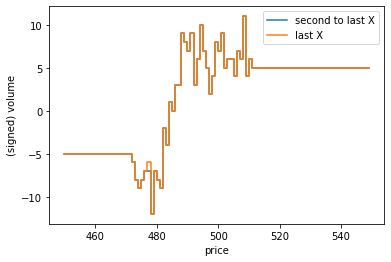

In [4]:
fig,ax = plt.subplots()
ax.step(range(450,550),h[-2,450:550])
ax.step(range(450,550),h[-1,450:550])
ax.legend(["second to last X", "last X"])
ax.set_xlabel("price")
ax.set_ylabel("(signed) volume")

In [5]:
a[-1]

4

A bid limit order is cancelled

In [6]:
ks[-1]

3

The cancellation happens at the 4th lowest value of the window (which we can check because we can see where the window start)

The above plot and prints allow us to check that the last transition worked as expected. Changing the index of the events in the history h allowed us to chech other individual events at will, and we did not notice any irregularity.

In [7]:
columns = ["bid","ask","mid","spread","time"]
df = pd.DataFrame(data = res, columns = columns)
mins = (df["time"]//60).astype("int").astype("str").str.zfill(2)
secs = (df["time"]%60*10**6).astype("int").astype("str").str.zfill(8)
dt = mins.str.cat(secs)
df["ts"] = pd.to_datetime(dt,format = "%M%S%f")

We change the arbitrary floats representing time to a datetime format (assuming that the floats represent a number of seconds, even though it does not necessarly), in order to use sampling methods in later questions.

Text(0, 0.5, 'probability of action')

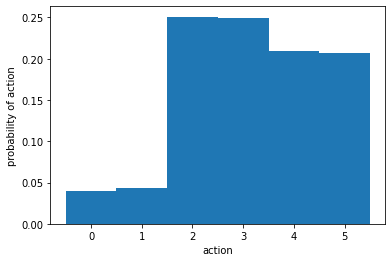

In [8]:
fig,ax = plt.subplots()
ax.hist(a,bins = [-0.5+i for i in range(7)],density = True)
ax.set_xlabel("action")
ax.set_ylabel("probability of action")

In [9]:
len(a)

29893

We excpect the intensity of the time of events to be around $2 \mu + 2K\lambda + 10K\theta = 55$ (because the initial values of the volumes are at 5, so we expect $5\theta$ to be close to the average intensity of the times of arrival for cancellation order on a given position of the window). Therefore, we excpect to have ~30 000 events in our simulation, which is the case. The relative number of events in each category are also distributed as expected (the event of the same type (market order/limit order/cancellation) have similar numbers of occurence regardless of the side of the lob they were related to; we excpected to have 6 times more limit orders than market orders based on the values of $\mu$ and $K\lambda$, which is verified)

## 2. Main analysis

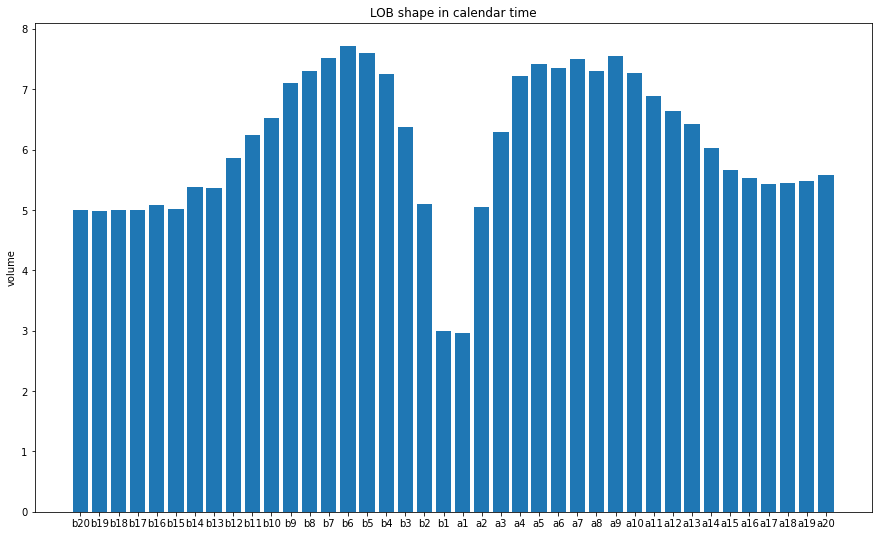

In [10]:
fig,ax = plt.subplots(figsize = (15,9))
ax.bar(range(40),np.abs(np.mean(lob,axis = 0)))
ax.set_xticks(range(40))
ax.set_xticklabels(["b"+str(20-i) for i in range(20)]+["a"+str(i+1) for i in range(20)])
ax.set_title("LOB shape in calendar time")
ax.set_ylabel("volume");

The average shape of the LOB is as expected, with a dip in volumes close to the spread.The peaks in the LOB right after and before the spread also make sense: neglecting the market orders, the initial value of X imposes that the volumes further away stay around 5, and the shape in between depends on the relative intensities of limit orders and cancellations. Here, we have significantly more limit orders, hence the peaks.

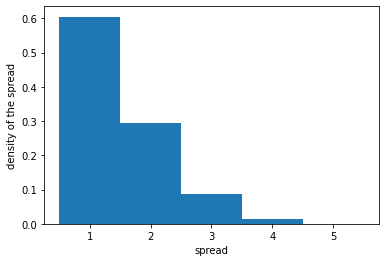

In [11]:
fig,ax = plt.subplots()
ax.hist(df["spread"],bins = [0.5+i for i in range(6)],density = True)
ax.set_xlabel("spread")
ax.set_ylabel("density of the spread");

Text(0, 0.5, 'mid movement')

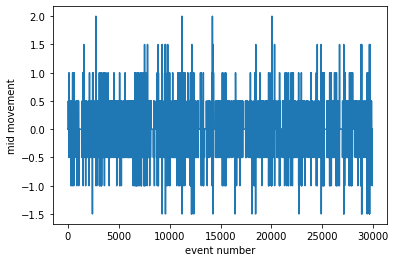

In [12]:
incs = df["mid"].diff().dropna()
fig,ax = plt.subplots()
ax.plot(incs)
ax.set_xlabel("event number")
ax.set_ylabel("mid movement")

In [13]:
np.mean(incs)

-0.0005018065034122842

In [14]:
np.median(incs)

0.0

As expected, the variation of the med price seems centered (the model is symetric between asks and bids), and is mostly confined to small values (smaller than 0.5), which is not surprising, as a large change in mid price requires a change twice as large in the spread, and since the spread mostly varies between 1 and 2, it can't vary too much either.

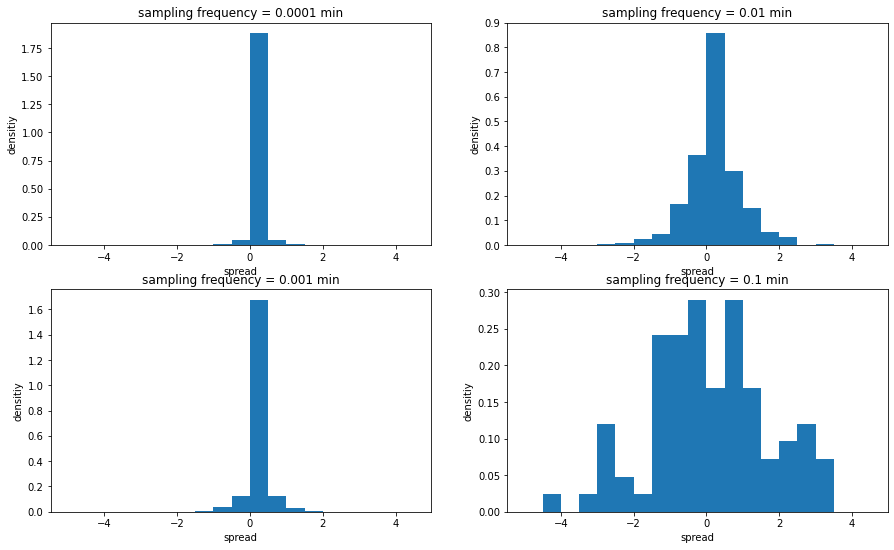

In [15]:
i = 0
j = 0
k = 0
fig,ax = plt.subplots(2,2, figsize = (15,9))
for t in ["0.0001","0.001","0.01","0.1"]:
    df_resampled = df.resample(t+"T",on = "ts").first()
    incs = df_resampled["mid"].diff().dropna()
    ax[i,j].hist(incs,bins = [-5+i/2 for i in range(20)],density = True)
    ax[i,j].set_xlabel("spread")
    ax[i,j].set_ylabel("densitiy")
    ax[i,j].set_title("sampling frequency = {} min".format(t)) 
    k += 1
    j = k//2
    i = k%2
    

As expected, for shorts sampling periods, the variation of the mid price spikes at 0, and the larger the sampling period, the wider the distribution of mid variation.

Text(0, 0.5, 'autocorellation of mid variations')

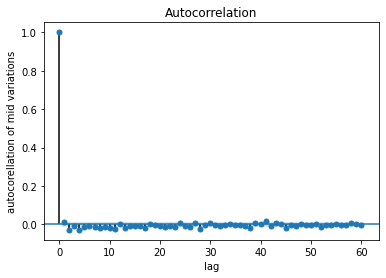

In [16]:
fig,ax = plt.subplots()
incs = df["mid"].diff().dropna()
plot_acf(incs, lags=60, ax = ax)
ax.set_xlabel("lag")
ax.set_ylabel("autocorellation of mid variations")

The model does not show memory in the mid price variation, which is to be expected, as the events are independant from each other.

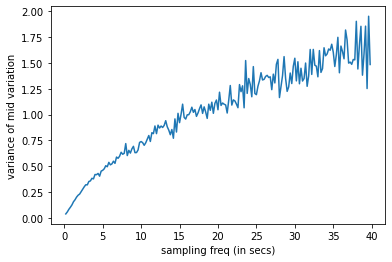

In [17]:
vs= []
for t in [str(i/100) for i in range(2,400,2)]:
    df_resampled = df.resample(t+"S",on = "ts").first()
    incs = df_resampled["mid"].diff().dropna()
    vs += [np.var(incs)]
fig,ax = plt.subplots()
ax.plot([i/10 for i in range(2,400,2)], vs)
ax.set_xlabel("sampling freq (in secs)")
ax.set_ylabel("variance of mid variation");

As expected from the distributions plotted previously, the variance increases with the sampling period. Early on, the variance increases faster, but the rate of progression stabilizes once a sampling period of around 10secs is reached, probably because we can add a lot of variance by removing the peak at 0 in the small sampling periods.